# 1D-ARC Neural Cellular Automata [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/46_1d_arc_nca.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [1]:
import json
import os

import jax
import jax.numpy as jnp
import mediapy
import optax
from flax import nnx
from tqdm.auto import tqdm

from cax.core.ca import CA
from cax.core.perceive import ConvPerceive, grad_kernel, identity_kernel
from cax.core.update import ResidualUpdate
from cax.utils import clip_and_uint8

## Configuration

In [2]:
seed = 0

num_spatial_dims = 1
channel_size = 64
num_kernels = 2
hidden_layer_sizes = (256,)
cell_dropout_rate = 0.0

num_embeddings = 10  # 10 colors in total
features = 3  # embed in rgb

batch_size = 16
num_steps = 64
learning_rate = 1e-3

ds_size = 96

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset

In [ ]:
!git clone https://github.com/khalil-research/1D-ARC.git

In [4]:
ds_path = "./1D-ARC/dataset"


def process(input, output):
	"""Process input and output from dataset."""
	input = jnp.squeeze(jnp.array(input, dtype=jnp.int32))
	output = jnp.squeeze(jnp.array(output, dtype=jnp.int32))
	assert input.shape == output.shape

	pad_size = ds_size - input.size
	pad_left, pad_right = pad_size // 2, pad_size - pad_size // 2

	input_padded = jnp.pad(input, (pad_left, pad_right))
	output_padded = jnp.pad(output, (pad_left, pad_right))

	return jnp.stack([input_padded, output_padded])


ds = []
tasks = []
for task_idx, task_name in enumerate(os.listdir(ds_path)):
	task_path = os.path.join(ds_path, task_name)
	for task_file in os.listdir(task_path):
		with open(os.path.join(task_path, task_file)) as f:
			data = json.load(f)
			input_output = jnp.array(
				[
					process(data["train"][0]["input"], data["train"][0]["output"]),
					process(data["train"][1]["input"], data["train"][1]["output"]),
					process(data["train"][2]["input"], data["train"][2]["output"]),
					process(data["test"][0]["input"], data["test"][0]["output"]),
				],
				dtype=jnp.int32,
			)
			tasks.append(task_name)
			ds.append(input_output)
ds = jnp.stack(ds)

unique_tasks = list(set(tasks))
task_to_idx = {task: idx for idx, task in enumerate(unique_tasks)}
tasks = jnp.array([task_to_idx[task] for task in tasks], dtype=jnp.int32)

In [5]:
from PIL import ImageColor

# ARC-AGI colors
colors = {
	0: "#000000",  # Black
	1: "#0074D9",  # Blue
	2: "#FF4136",  # Red
	3: "#2ECC40",  # Green
	4: "#FFDC00",  # Yellow
	5: "#AAAAAA",  # Grey
	6: "#F012BE",  # Fuchsia
	7: "#FF851B",  # Orange
	8: "#7FDBFF",  # Teal
	9: "#870C25",  # Brown
}

# Convert all ARC colors to RGB using PIL
color_lookup = jnp.array([ImageColor.getrgb(hex) for hex in colors.values()]) / 255

In [6]:
key, subkey = jax.random.split(key)

tasks = jax.random.permutation(subkey, tasks)
ds = jax.random.permutation(subkey, ds)

split = int(0.9 * ds.shape[0])

train_ds = ds[:split]
train_tasks = tasks[:split]

test_ds = ds[split:]
test_tasks = tasks[split:]

## Sample initial state

In [7]:
def create_state_with_sample(ca, sample, key):
	"""Create state with sample."""
	# Sample input and target
	(
		(input_embed_1, output_embed_1),
		(input_embed_2, output_embed_2),
		(input_embed_3, output_embed_3),
		(input_embed, _),
	) = ca.embed_input(sample)

	# Create context
	context_1 = jnp.concatenate(
		[
			input_embed_1,
			output_embed_1,
			input_embed_2,
			output_embed_2,
			input_embed_3,
			output_embed_3,
		],
		axis=-1,
	)
	context_2 = jnp.concatenate(
		[
			input_embed_1,
			output_embed_1,
			input_embed_3,
			output_embed_3,
			input_embed_2,
			output_embed_2,
		],
		axis=-1,
	)
	context_3 = jnp.concatenate(
		[
			input_embed_2,
			output_embed_2,
			input_embed_1,
			output_embed_1,
			input_embed_3,
			output_embed_3,
		],
		axis=-1,
	)
	context_4 = jnp.concatenate(
		[
			input_embed_3,
			output_embed_3,
			input_embed_1,
			output_embed_1,
			input_embed_2,
			output_embed_2,
		],
		axis=-1,
	)
	context_5 = jnp.concatenate(
		[
			input_embed_2,
			output_embed_2,
			input_embed_3,
			output_embed_3,
			input_embed_1,
			output_embed_1,
		],
		axis=-1,
	)
	context_6 = jnp.concatenate(
		[
			input_embed_3,
			output_embed_3,
			input_embed_2,
			output_embed_2,
			input_embed_1,
			output_embed_1,
		],
		axis=-1,
	)
	context = jax.random.choice(
		key, jnp.array([context_1, context_2, context_3, context_4, context_5, context_6])
	)

	# Initialize state
	state = jnp.zeros((ds_size, channel_size))
	# state = state.at[..., :3].set(input_embed)
	state = state.at[..., 3 : 18 + 3].set(context)
	state = state.at[..., -10:].set(jax.nn.one_hot(sample[-1, 0], num_classes=10))
	return state, sample[-1, -1]


def sample_state(ca, key):
	"""Sample state with data augmentation."""
	key_sample, key_flip, key_perm, key_init = jax.random.split(key, 4)

	# Sample dataset
	_ = jax.random.choice(key_sample, train_tasks)
	sample = jax.random.choice(key_sample, train_ds)

	# Flip sample half of the time
	flip = jax.random.bernoulli(key_flip, p=0.5)
	sample = jnp.where(flip < 0.5, sample, jnp.flip(sample, axis=-1))

	# Permute colors
	color_perm = jnp.concatenate(
		[jnp.array([0], dtype=jnp.int32), jax.random.permutation(key_perm, jnp.arange(9)) + 1]
	)
	sample = color_perm[sample]

	return create_state_with_sample(ca, sample, key_init)


def sample_state_test(ca, key):
	"""Sample state with data augmentation."""
	key_sample, key_init = jax.random.split(key)

	# Sample dataset
	_ = jax.random.choice(key_sample, test_tasks)
	sample = jax.random.choice(key_sample, test_ds)

	return create_state_with_sample(ca, sample, key_init)

## Instantiate system

In [8]:
perceive = ConvPerceive(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	rngs=rngs,
	kernel_size=(3,),
	feature_group_count=channel_size,
)
update = ResidualUpdate(
	num_spatial_dims=num_spatial_dims,
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	hidden_layer_sizes=hidden_layer_sizes,
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
	zeros_init=True,
)
embed_input = nnx.Embed(num_embeddings=num_embeddings, features=features, rngs=rngs)

In [9]:
class ARCNCA(CA):
	"""1D-ARC Neural Cellular Automata."""

	def __init__(self, perceive, update, embed_input):
		"""Initialize 1D-ARC NCA."""
		super().__init__(perceive, update)
		self.embed_input = embed_input

		# Initialize kernel with sobel filters
		kernel = jnp.concatenate(
			[identity_kernel(ndim=num_spatial_dims), grad_kernel(ndim=num_spatial_dims)], axis=-1
		)
		kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
		self.perceive.conv.kernel = nnx.Param(kernel)

	@nnx.jit
	def render(self, state):
		"""Render state to RGB."""
		# Extract classification logits
		logits = state[..., -10:]

		# Render to RGB
		rgb = color_lookup[jnp.argmax(logits, axis=-1)]

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgb)

In [10]:
ca = ARCNCA(perceive, update, embed_input)

In [11]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", sum(x.size for x in jax.tree.leaves(params)))

Number of params: 49886


## Train

In [12]:
num_train_steps = 100_000
lr_sched = optax.linear_schedule(
	init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=num_train_steps // 10
)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

params = nnx.All(
	nnx.Param,
	# nnx.Not(nnx.PathContains("perceive"))
)
optimizer = nnx.Optimizer(ca, optimizer, wrt=params)

### Loss

In [13]:
def ce(state, output):
	"""Cross-entropy."""
	return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(state[..., -10:], output))

In [14]:
@nnx.jit
def loss_fn(ca, key):
	"""Loss function."""
	keys = jax.random.split(key, batch_size)
	state, output = jax.vmap(sample_state, in_axes=(None, 0))(ca, keys)

	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state, _ = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	loss = ce(state, output)
	return loss

### Train step

In [15]:
@nnx.jit
def train_step(ca, optimizer, key):
	"""Train step."""
	loss, grad = nnx.value_and_grad(loss_fn, argnums=nnx.DiffState(0, params))(ca, key)
	optimizer.update(grad)
	return loss

### Main loop

In [16]:
def accuracy(ca, eval_ds):
	"""Compute accuracy."""
	eval_size = eval_ds.shape[0]
	state, output = jax.vmap(create_state_with_sample, in_axes=(None, 0, None))(ca, eval_ds, key)

	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	_, state = nnx.split_rngs(splits=eval_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	# Convert logits to symbols
	final_state_logits = state[:, -1, :, -10:]
	final_state = jnp.argmax(final_state_logits, axis=-1)

	# Successful if all symbols match in the prediction
	return jnp.sum(jnp.all(final_state == output, axis=-1)) / eval_size

In [ ]:
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []
for i in pbar:
	key, subkey = jax.random.split(key)
	loss = train_step(ca, optimizer, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		test_acc = accuracy(ca, test_ds)
		train_acc = accuracy(ca, train_ds)
		pbar.set_postfix(
			{
				"Average Loss": f"{avg_loss:.3e}",
				"Test Accuracy": f"{test_acc:.2%}",
				"Train Accuracy": f"{train_acc:.2%}",
			}
		)

## Run

In [32]:
num_examples = 8

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_examples)
state_init, output = jax.vmap(sample_state_test, in_axes=(None, 0))(ca, keys)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state_final, states = nnx.split_rngs(splits=num_examples)(
	nnx.vmap(
		lambda ca, state: ca(state, num_steps=num_steps),
		in_axes=(state_axes, 0),
	)
)(ca, state_init)

## Visualize

Success,Success,Success,Success,Success,Failure,Failure,Success

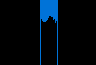
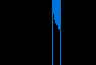
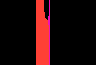
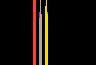
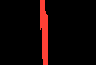
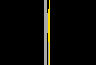
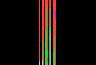
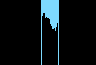

In [33]:
output_pred = jnp.argmax(state_final[..., -10:], axis=-1)
success = jnp.all(output_pred == output, axis=-1)

states = jnp.concatenate([state_init[:, None], states], axis=1)
frames = nnx.vmap(
	lambda ca, state: ca.render(state),
	in_axes=(None, 0),
)(ca, states)

# Add titles to each image to indicate success
titles = ["Success" if s else "Failure" for s in success]
mediapy.show_images(frames, width=196, height=128, titles=titles)